In [24]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import joblib


In [25]:
df= pd.read_csv("../data/processed/telco_clean.csv")

In [27]:
X = df.drop(['customerID', 'Churn', 'MonthlyCharges'], axis =1)
y = df['Churn']

In [28]:
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

In [30]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [47]:
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(class_weight='balanced',
                                     random_state=42))
])

In [48]:
param_grid = {
    "model__n_estimators":[100,200],
    "model__max_depth":[5,10,20],
    "model__min_samples_split":[2,5]
}

grid = GridSearchCV(pipe,param_grid,cv=5,scoring='roc_auc',n_jobs=-1)
grid.fit(X,y)

print("Best Params:", grid.best_params_)
print("Best CV ROC AUC:", grid.best_score_)


Best Params: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV ROC AUC: 0.842428779285217


In [49]:
y_pred = grid.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          No       0.95      0.82      0.88      5163
         Yes       0.64      0.89      0.74      1869

    accuracy                           0.84      7032
   macro avg       0.80      0.85      0.81      7032
weighted avg       0.87      0.84      0.85      7032



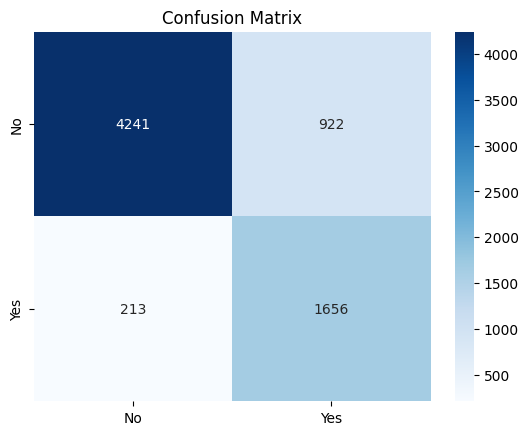

In [50]:
cm = confusion_matrix(y,y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes']
           )
plt.title("Confusion Matrix")
plt.savefig("../reports/figures/confusion_matrix.png")
plt.show()

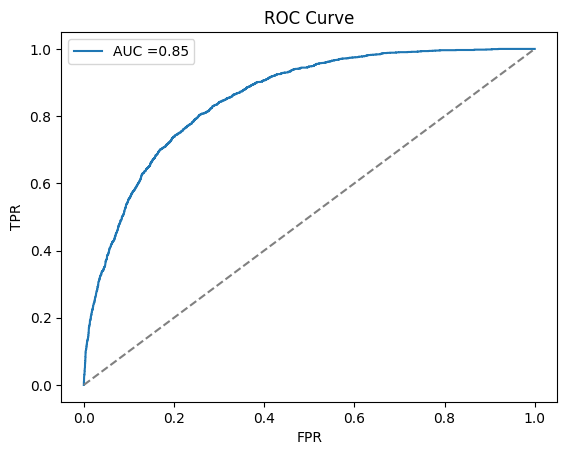

In [44]:
best_pipe = grid.best_estimator_
pos_idx = list(best_pipe.classes_).index('Yes')
y_probs = best_pipe.predict_proba(X)[:, pos_idx]
                        

fpr, tpr, _ = roc_curve(y, y_probs, pos_label='Yes')
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = f"AUC ={roc_auc:.2f}")
plt.plot([0,1],[0,1],"--", color='grey')
plt.xlabel("FPR"); plt.ylabel("TPR");plt.title("ROC Curve")
plt.legend()
plt.savefig("../reports/figures/roc_curve.png")
plt.show()

